In [4]:
def parseGEvalResult(filename):
    """Parses the specified file and returns a list of valid number lists.

    Args:
        filename: The name of the text file to parse.

    Returns:
        A list of lists, where each inner list contains 6 numbers.

    Raises:
        AssertionError: If the first number in a group of 3 lines does not match.
    """

    output_list = []
    line_num = 1  # Keep track of line numbers
    group_count = 0  # Track groups of 3 lines
    last_first_num = None

    with open(filename, 'r') as file:
        for line in file:
            if not line.startswith(tuple('0123456789')):  # Check if line starts with a digit
                continue

            numbers = line.strip().split()

            if len(numbers) != 6:
                raise ValueError(f"Invalid number of values on line {line_num}")

            # Check for consistency in groups of 3
            if group_count % 3 == 0:
                last_first_num = numbers[0]
            else:
                if numbers[0] != last_first_num:
                    raise AssertionError(f"Inconsistent first number on line {line_num}")

            numbers[0] = numbers[0] + ','
            numbers = [int(num.split(',')[0]) for num in numbers]

            output_list.append(numbers)
            group_count += 1

            line_num += 1

    return output_list

In [5]:
cnn_scores = parseGEvalResult('cnn_responses.txt')
news_scores = parseGEvalResult('news_responses.txt')
reddit_scores = parseGEvalResult('reddit_responses.txt')
xsum_scores = parseGEvalResult('xsum_responses.txt')

In [6]:
from icecream import ic

def process_scores(scores):
  """
  Processes a nested list of scores and returns a new list with weighted sums.

  Args:
      scores: A nested list of scores, where each score is a list of 6 numbers.

  Returns:
      A new list containing the item number and weighted sums for every 3 instances.
  """
  final_list = []
  for i in range(0, len(scores), 3):
    item_num = scores[i][0]
    window = scores[i:i+3]
    weighted_sums = []
    for score in window:
      # Calculate softmax of the last 5 elements
      percent_sum = sum(val for val in score[1:])
      softmax_scores = [x / percent_sum  for x in score[1:]]
      # Calculate weighted sum
      weighted_sum = sum((5-i) * s for i, s in enumerate(softmax_scores))
      weighted_sums.append(weighted_sum)
    final_list.append([item_num] + weighted_sums)
  return final_list


In [6]:
scores = [[1, 60, 10, 10, 10, 10], [1, 40, 10, 10, 10, 10], [1, 6, 1, 1, 1, 1]]
print(process_scores(scores))

ic| softmax_scores: [0.6, 0.1, 0.1, 0.1, 0.1]
ic| softmax_scores: [0.5, 0.125, 0.125, 0.125, 0.125]
ic| softmax_scores: [0.6, 0.1, 0.1, 0.1, 0.1]


[[1, 4.0, 3.75, 4.0]]


In [7]:
cnn_scores = process_scores(cnn_scores)
news_scores = process_scores(news_scores)
xsum_scores = process_scores(xsum_scores)
reddit_scores = process_scores(reddit_scores)

In [24]:
import csv

def write_to_csv(scores, filename):
  with open (filename, 'w') as file:
    writer = csv.writer(file)
    writer.writerows(scores)

write_to_csv(cnn_scores, 'cnn_scores.csv')
write_to_csv(news_scores, 'news_scores.csv')
write_to_csv(xsum_scores, 'xsum_scores.csv')
write_to_csv(reddit_scores, 'reddit_scores.csv')

In [9]:
import matplotlib.pyplot as plt

def create_boxplot(cnn_scores, news_scores, xsum_scores, reddit_scores):
    """
    Creates a boxplot comparing scores from four nested lists.

    Args:
        cnn_scores: A nested list of CNN scores.
        news_scores: A nested list of news scores.
        xsum_scores: A nested list of XSum scores.
        reddit_scores: A nested list of Reddit scores.
    """

    # Extract scores from each nested list
    scores = [
        [item[1] for item in cnn_scores],  # Gold summary scores
        [item[2] for item in cnn_scores],  # Original summary scores
        [item[3] for item in cnn_scores],  # Paraphrased summary scores

        [item[1] for item in news_scores],
        [item[2] for item in news_scores], 
        [item[3] for item in news_scores],

        [item[1] for item in xsum_scores], 
        [item[2] for item in xsum_scores], 
        [item[3] for item in xsum_scores], 

        [item[1] for item in reddit_scores], 
        [item[2] for item in reddit_scores], 
        [item[3] for item in reddit_scores] 
    ]

    # Create the box plot
    plt.figure(figsize=(10, 6))  # Adjust figure size as needed 
    plt.ylim(3.5, 5.0)
    plt.boxplot(scores)

    # Labels and Title
    plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 
               ['CNN Gold', 'CNN Original', 'CNN Paraphrased', 
                'News Gold', 'News Original', 'News Paraphrased', 
                'XSum Gold', 'XSum Original', 'XSum Paraphrased',
                'Reddit Gold', 'Reddit Original', 'Reddit Paraphrased'], rotation=45)
    plt.title('Comparison of Summary Scores')

    plt.show()

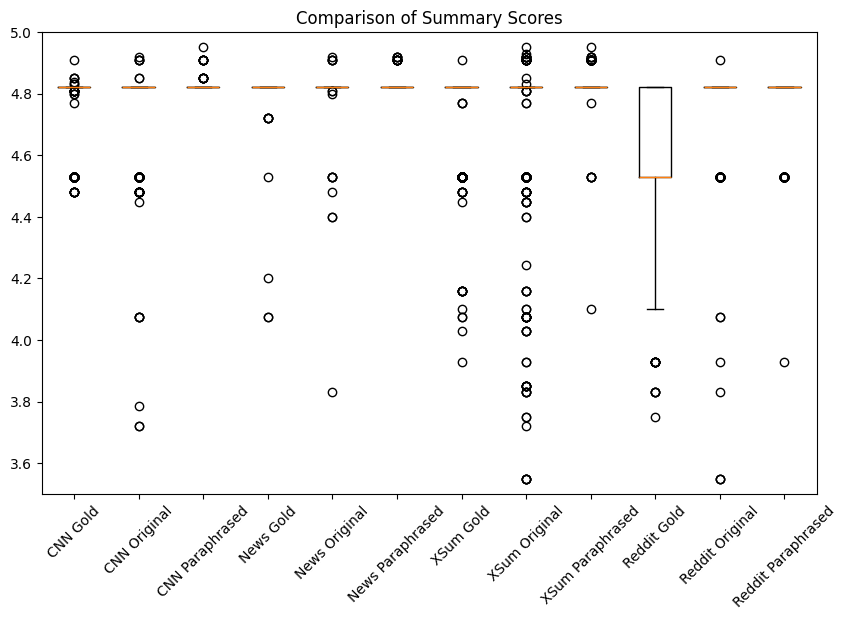

In [10]:
create_boxplot(cnn_scores, news_scores, xsum_scores, reddit_scores)

In [11]:
def create_grouped_barplot(cnn_scores, news_scores, xsum_scores, reddit_scores):
    """
    Creates a grouped bar plot comparing mean scores from four nested lists.

    Args:
        cnn_scores: A nested list of CNN scores.
        news_scores: A nested list of news scores.
        xsum_scores: A nested list of XSum scores.
        reddit_scores: A nested list of Reddit scores.
    """

    # Extract mean scores from each nested list
    mean_scores = []
    for dataset in [cnn_scores, news_scores, xsum_scores, reddit_scores]:
        for j in range(3):
            mean_scores.append([item[j + 1] for item in dataset])

    means = [sum(sublist) / len(sublist) for sublist in mean_scores]
    print(means)

    # Colors
    purple_shades = ['#d0bfff', '#9966ff', '#6633cc']
    red_shades = ['#ffb3ba', '#ff6961', '#ff1410']
    green_shades = ['#c8f7c5', '#86e27f', '#258039']
    blue_shades = ['#b3e2e2', '#66b3b3', '#008080']

    # Bar positions
    bar_width = 0.2
    x_positions = [0.5 + i + j * bar_width for i in range(4) for j in range(3)] 

    # Create the bars
    plt.figure(figsize=(10, 6))
    plt.ylim(4.78, 4.83)
    plt.bar(x_positions[0:3], means[0], width=bar_width, color=purple_shades, label='CNN')
    plt.bar(x_positions[3:6], means[1], width=bar_width, color=red_shades, label='News')
    plt.bar(x_positions[6:9], means[2], width=bar_width, color=green_shades, label='XSum')
    plt.bar(x_positions[9:12], means[3], width=bar_width, color=blue_shades, label='Reddit')

    # Labels, title, and legend
    plt.xticks(x_positions, ['Gold', 'Original', 'Paraphrased']*4, rotation=45)  
    plt.title('Comparison of Mean Summary Scores')
    plt.legend()

    plt.show()

[4.788530224096306, 4.783538712245579, 4.820917508417477, 4.79363636363636, 4.735363636363633, 4.831818181818181, 4.755243519352735, 4.734187357932195, 4.8238516179952144, 4.5608307959982435, 4.691460055096404, 4.764820936639102]


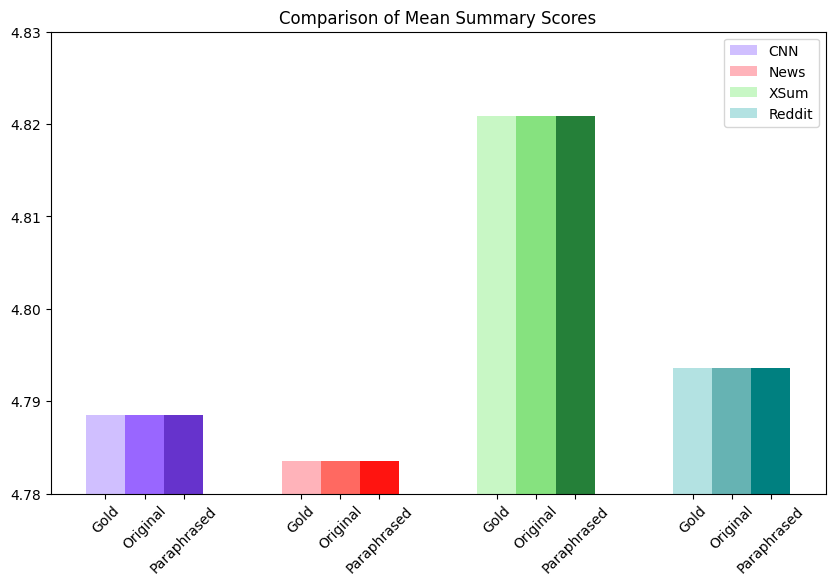

In [12]:
create_grouped_barplot(cnn_scores, news_scores, xsum_scores, reddit_scores)